<a href="https://colab.research.google.com/github/cgold212/assignment3inverseMethod/blob/main/chenCopy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# imports
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import os
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
import shutil
import random

#try save
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
trfm = transforms.Compose([transforms.Resize((200,200)),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.ToTensor()]) 

data  = datasets.StanfordCars(root='Stanford_cars_dataset' , transform= None,  download = True)
test_data  = datasets.StanfordCars(root='Stanford_cars_dataset' , split= 'test', transform= None,  download = True)

  0%|          | 0/330960 [00:00<?, ?it/s]

Extracting Stanford_cars_dataset/stanford_cars/car_devkit.tgz to Stanford_cars_dataset/stanford_cars


  0%|          | 0/979269282 [00:00<?, ?it/s]

Extracting Stanford_cars_dataset/stanford_cars/cars_train.tgz to Stanford_cars_dataset/stanford_cars
Using downloaded and verified file: Stanford_cars_dataset/stanford_cars/car_devkit.tgz
Extracting Stanford_cars_dataset/stanford_cars/car_devkit.tgz to Stanford_cars_dataset/stanford_cars


  0%|          | 0/977350468 [00:00<?, ?it/s]

Extracting Stanford_cars_dataset/stanford_cars/cars_test.tgz to Stanford_cars_dataset/stanford_cars


  0%|          | 0/185758 [00:00<?, ?it/s]

In [ ]:
# load annotations and labels
mat_train= loadmat('./Stanford_cars_dataset/stanford_cars/devkit/cars_train_annos.mat')
mat_test= loadmat('./Stanford_cars_dataset/stanford_cars/cars_test_annos_withlabels.mat')
meta = loadmat('./Stanford_cars_dataset/stanford_cars/devkit/cars_meta.mat')

# get classes
labels = list()
for l in meta['class_names'][0]:
    labels.append(l[0].replace('/','').replace(' ','_'))

# get train labels
train = list()
for example in mat_train['annotations'][0]:
    label  = labels[example[-2][0][0]-1]
    image  = example[-1][0]
    class_car= example[4][0][0]
    train.append((image, class_car, label))

# get test labels
test = list()
for example in mat_test['annotations'][0]:
    label  = labels[example[-2][0][0]-1]
    image  = example[-1][0]
    class_car= example[4][0][0]
    test.append((image, class_car, label))

# create dirs for new dataset
os.mkdir('./ordered_stanford_dataset')
os.mkdir('./ordered_stanford_dataset/train')
os.mkdir('./ordered_stanford_dataset/valid')
os.mkdir('./ordered_stanford_dataset/test')

# get all filenames for train and test
imgs_train = os.listdir('./Stanford_cars_dataset/stanford_cars/cars_train')
imgs_test = os.listdir('./Stanford_cars_dataset/stanford_cars/cars_test')

# create dir for each label in train and test
for i in labels:
    os.mkdir('./ordered_stanford_dataset/train/'+i)
    os.mkdir('./ordered_stanford_dataset/valid/'+i)
    os.mkdir('./ordered_stanford_dataset/test/'+i)



In [ ]:
# move files from train to specific folder in the new dataset 
for image in imgs_train:
    for annos in train:
        img_name = annos[0]
        img_label = annos[2]
        if image == img_name:
            src = './Stanford_cars_dataset/stanford_cars/cars_train/'+image
            des = './ordered_stanford_dataset/train/'+img_label+'/'+image
            shutil.move(src,des)
            break
# move files from test to specific folder in the new dataset 
for image in imgs_test:
    for annos in test:
        img_name = annos[0]
        img_label = annos[2]
        if image == img_name:
            src = './Stanford_cars_dataset/stanford_cars/cars_test/'+image
            des = './ordered_stanford_dataset/test/'+img_label+'/'+image
            shutil.move(src,des)
            break

In [ ]:
# get valid dataset from train
val_part = 0.1
for l in labels:
    files = os.listdir('./ordered_stanford_dataset/train/'+l)
    num_files = len(files)
    num_val_files = int(np.floor(num_files * val_part))
    if num_val_files > 0:
        val_idxs = random.sample(range(0, num_files),num_val_files)   # pick random images for validation
        for idx in val_idxs:
            src = './ordered_stanford_dataset/train/' + l + '/' + files[idx]
            des = './ordered_stanford_dataset/valid/' + l + '/' + files[idx]
            shutil.move(src, des)
# get valid dataset from test
for l in labels:
    files = os.listdir('./ordered_stanford_dataset/test/'+l)
    num_files = len(files)
    num_val_files = int(np.floor(num_files * val_part))
    if num_val_files > 0:
        val_idxs = random.sample(range(0, num_files),num_val_files)   # pick random images for validation
        for idx in val_idxs:
            src = './ordered_stanford_dataset/test/' + l + '/' + files[idx]
            des = './ordered_stanford_dataset/valid/' + l + '/' + files[idx]
            shutil.move(src, des)

In [ ]:
# get ordered datasets
# stats = ((0, 0, 0), (1, 1, 1))
trfm = transforms.Compose([
                          transforms.Resize((256, 256)),
                          T.RandomCrop(size=(100, 100)),
                          transforms.RandomHorizontalFlip(0.5),
                          #  transforms.ColorJitter(),
                          transforms.ToTensor(),
                          # transforms.Normalize(*stats, inplace = True)
                          ]) 
trfm_test = transforms.Compose([
                          transforms.Resize((256, 256)),
                          # T.RandomCrop(size=(128, 128)),
                          transforms.RandomHorizontalFlip(0.5),
                          #  transforms.ColorJitter(),
                          transforms.ToTensor(),
                          # transforms.Normalize(*stats, inplace = True)
                          ])

train_data = datasets.ImageFolder('./ordered_stanford_dataset/train',transform= trfm)
val_data = datasets.ImageFolder('./ordered_stanford_dataset/valid',transform= trfm)
test_data = datasets.ImageFolder('./ordered_stanford_dataset/test',transform= trfm)

In [ ]:
print('number of images in train - '+str(len(train_data)))
print('number of images in validation - '+str(len(val_data)))
print('number of images in test - '+str(len(test_data)))

number of images in train - 7410
number of images in validation - 1461
number of images in test - 7314


In [ ]:
# get data loaders
def get_data_loaders(train_data,val_data,test_data,batch_size):

    train_loader = DataLoader(train_data, batch_size=batch_size, 
                              shuffle=True, num_workers=2)
    val_loader = DataLoader(val_data, batch_size=batch_size, 
                              shuffle=True, num_workers=2)
    test_loader = DataLoader(test_data, batch_size=batch_size, 
                              shuffle=True, num_workers=2)
    
    return train_loader, val_loader, test_loader

In [ ]:
batch_size = 32
train_loader, val_loader, test_loader = get_data_loaders(train_data,val_data,test_data,batch_size)

In [ ]:
# function to show bach images
def show(imgs,num2show):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((imgs.detach()[:num2show]), nrow=8).permute(1, 2, 0))
    return None

In [ ]:
# batch_train_images, train_labels = next(iter(train_loader))
# show(batch_train_images,5)

In [ ]:
# batch_test_images, test_labels = next(iter(test_loader))
# show(batch_test_images,5)

In [ ]:
# batch_val_images, val_labels = next(iter(val_loader))
# show(batch_val_images,5)

In [ ]:
# train_data.classes[53]

In [ ]:
# len(labels)

In [ ]:
# val_labels

In [ ]:
# train_loader.batch_size

In [ ]:
from torchvision.models import resnet50


In [ ]:
# train function
def train(model, train_loader, val_loader, num_epochs, criterion, optimizer, grad_clip = None, checkpoint_path = None):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    train_losses_iter = []
    n_iters = 0
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        total_correct = 0
        total_instances = 0
        for images, labels in train_loader:
            n_iters += 1
            optimizer.zero_grad()
            if torch.cuda.is_available():
                images = images.to(device)
                labels = labels.to(device)

            one_hot = torch.zeros((64, 196))
            one_hot[torch.arange(len(labels)), labels] = 1
            # print(one_hot[0,:])
            one_hot = one_hot.to(device)

            outputs = model(images)
            outputs = torch.sigmoid(outputs)
            # print(one_hot.shape)
            # print(outputs.shape)
            if outputs.shape[0] == one_hot.shape[0]:
              # print(outputs.shape)
              loss = criterion(outputs, one_hot)  
              loss.backward() 

            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            train_loss += loss.item()
            train_losses_iter.append(loss.item()/train_loader.batch_size)

            # get classifications of the batch
            classifications = torch.argmax(outputs, dim=1)
            correct_predictions = sum(classifications == labels).item()
            total_correct += correct_predictions
            total_instances += len(images)
            if n_iters % 50 == 0:
                print('Iter - %d Train loss - %f'%(n_iters , loss.item()/train_loader.batch_size))

        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                if torch.cuda.is_available():
                    images = images.cuda()
                    labels = labels.cuda()
                outputs = model(images)
                outputs = torch.sigmoid(outputs)          
                one_hot = torch.zeros((64, 196))
                one_hot[torch.arange(len(labels)), labels] = 1
                # print(one_hot[0,:])
                one_hot = one_hot.to(device)    
                if outputs.shape[0] == one_hot.shape[0]:
                  # print(outputs.shape)
                  loss = criterion(outputs, one_hot)  
                  val_loss += loss.item()
                  _, predicted = torch.max(outputs.data, 1)
                  total += labels.size(0)
                  correct += (predicted == labels).sum().item()
        cur_train_acc = round(total_correct/total_instances, 3)
        train_accuracies.append(cur_train_acc)
        train_losses.append(train_loss/train_loader.batch_size)
        val_losses.append(val_loss/val_loader.batch_size)
        val_accuracies.append(correct/total)
        if epoch % 10 == 0:
            plot_results_iter(train_losses_iter, val_losses, val_accuracies, train_accuracies)
        print('Epoch - %d | train acc - %f%% | val acc - %f%%'%(epoch ,100*cur_train_acc ,100*correct/total))
        if (checkpoint_path is not None) and epoch > 0 and epoch % 5 == 0:
            torch.save(model.state_dict(), checkpoint_path.format(epoch+270))
    return train_losses, val_losses, val_accuracies, train_accuracies

def plot_results(train_losses, val_losses, val_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.plot(train_losses, label='train')
    ax1.plot(val_losses, label='val')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax2.plot(np.array(val_accuracies)*100)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    plt.show()
def plot_results_iter(train_losses, val_losses, val_accuracies, train_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.plot(train_losses, label='train')
    # ax1.plot(val_losses, label='val')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax2.plot(np.array(train_accuracies)*100,label='train')
    ax2.plot(np.array(val_accuracies)*100,label='val')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Iter - 50 Train loss - 0.082228
Iter - 100 Train loss - 0.082162


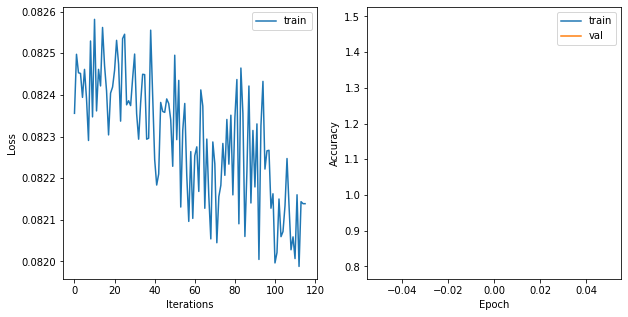

Epoch - 0 | train acc - 0.800000% | val acc - 1.491477%
Iter - 150 Train loss - 0.081637
Iter - 200 Train loss - 0.080917
Epoch - 1 | train acc - 3.400000% | val acc - 4.545455%
Iter - 250 Train loss - 0.080945
Iter - 300 Train loss - 0.080179
Epoch - 2 | train acc - 6.500000% | val acc - 7.315341%
Iter - 350 Train loss - 0.079165
Iter - 400 Train loss - 0.079213
Iter - 450 Train loss - 0.078588
Epoch - 3 | train acc - 8.800000% | val acc - 9.161932%
Iter - 500 Train loss - 0.077557
Iter - 550 Train loss - 0.077421
Epoch - 4 | train acc - 10.700000% | val acc - 10.795455%
Iter - 600 Train loss - 0.076643
Iter - 650 Train loss - 0.076973
Epoch - 5 | train acc - 12.900000% | val acc - 12.215909%
Iter - 700 Train loss - 0.075142
Iter - 750 Train loss - 0.076351
Iter - 800 Train loss - 0.075426
Epoch - 6 | train acc - 14.700000% | val acc - 13.494318%
Iter - 850 Train loss - 0.074456
Iter - 900 Train loss - 0.075211
Epoch - 7 | train acc - 15.900000% | val acc - 13.991477%
Iter - 950 Train

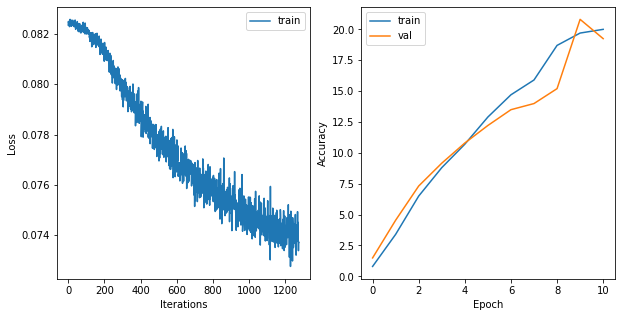

Epoch - 10 | train acc - 20.000000% | val acc - 19.247159%
Iter - 1300 Train loss - 0.074109
Iter - 1350 Train loss - 0.074437
Epoch - 11 | train acc - 22.200000% | val acc - 20.525568%
Iter - 1400 Train loss - 0.073988
Iter - 1450 Train loss - 0.073366
Iter - 1500 Train loss - 0.072917
Epoch - 12 | train acc - 22.900000% | val acc - 20.880682%
Iter - 1550 Train loss - 0.072812
Iter - 1600 Train loss - 0.072391
Epoch - 13 | train acc - 23.700000% | val acc - 20.738636%
Iter - 1650 Train loss - 0.073074
Iter - 1700 Train loss - 0.073452
Epoch - 14 | train acc - 25.300000% | val acc - 23.508523%
Iter - 1750 Train loss - 0.072277
Iter - 1800 Train loss - 0.072614
Iter - 1850 Train loss - 0.072829
Epoch - 15 | train acc - 26.400000% | val acc - 23.508523%
Iter - 1900 Train loss - 0.072554
Iter - 1950 Train loss - 0.072990
Epoch - 16 | train acc - 26.400000% | val acc - 23.650568%
Iter - 2000 Train loss - 0.072444
Iter - 2050 Train loss - 0.072340
Epoch - 17 | train acc - 28.700000% | val a

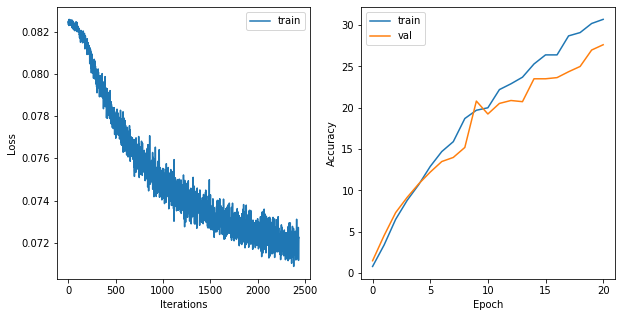

Epoch - 20 | train acc - 30.700000% | val acc - 27.627841%
Iter - 2450 Train loss - 0.071208
Iter - 2500 Train loss - 0.071242
Iter - 2550 Train loss - 0.071596
Epoch - 21 | train acc - 31.500000% | val acc - 27.485795%
Iter - 2600 Train loss - 0.071069
Iter - 2650 Train loss - 0.071949
Epoch - 22 | train acc - 32.100000% | val acc - 28.977273%
Iter - 2700 Train loss - 0.071659
Iter - 2750 Train loss - 0.071331
Epoch - 23 | train acc - 33.400000% | val acc - 27.911932%
Iter - 2800 Train loss - 0.071209
Iter - 2850 Train loss - 0.071007
Iter - 2900 Train loss - 0.071233
Epoch - 24 | train acc - 34.300000% | val acc - 29.119318%
Iter - 2950 Train loss - 0.071992
Iter - 3000 Train loss - 0.071500
Epoch - 25 | train acc - 35.100000% | val acc - 29.403409%
Iter - 3050 Train loss - 0.071854
Iter - 3100 Train loss - 0.070500
Epoch - 26 | train acc - 35.500000% | val acc - 31.889205%
Iter - 3150 Train loss - 0.070615
Iter - 3200 Train loss - 0.070566
Epoch - 27 | train acc - 36.600000% | val a

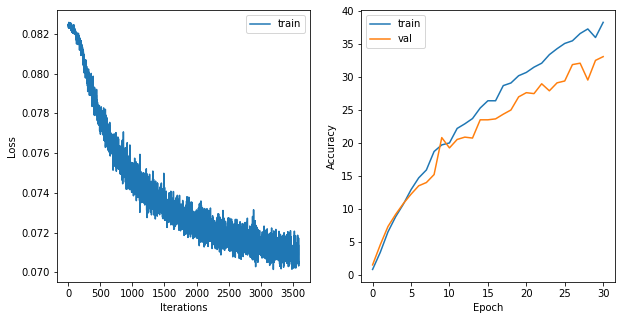

Epoch - 30 | train acc - 38.300000% | val acc - 33.096591%
Iter - 3600 Train loss - 0.071320
Iter - 3650 Train loss - 0.071507
Iter - 3700 Train loss - 0.071164
Epoch - 31 | train acc - 38.400000% | val acc - 33.593750%
Iter - 3750 Train loss - 0.070562
Iter - 3800 Train loss - 0.071228
Epoch - 32 | train acc - 38.600000% | val acc - 31.605114%
Iter - 3850 Train loss - 0.071536
Iter - 3900 Train loss - 0.071641
Epoch - 33 | train acc - 39.300000% | val acc - 35.795455%
Iter - 3950 Train loss - 0.070987
Iter - 4000 Train loss - 0.070807
Iter - 4050 Train loss - 0.070922
Epoch - 34 | train acc - 40.200000% | val acc - 31.676136%
Iter - 4100 Train loss - 0.070370
Iter - 4150 Train loss - 0.070252
Epoch - 35 | train acc - 40.900000% | val acc - 35.227273%
Iter - 4200 Train loss - 0.070460
Iter - 4250 Train loss - 0.071142
Epoch - 36 | train acc - 41.500000% | val acc - 34.659091%
Iter - 4300 Train loss - 0.070258
Iter - 4350 Train loss - 0.070755
Iter - 4400 Train loss - 0.070601
Epoch - 3

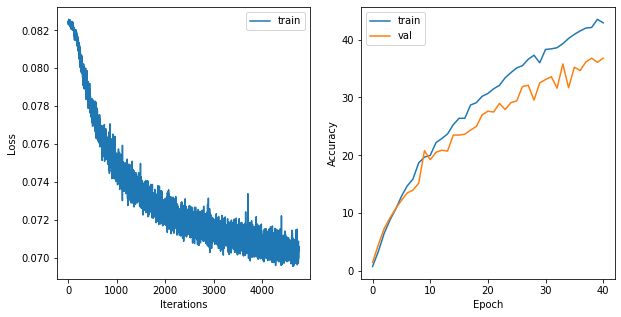

Epoch - 40 | train acc - 42.900000% | val acc - 36.789773%
Iter - 4800 Train loss - 0.070681
Iter - 4850 Train loss - 0.070206
Epoch - 41 | train acc - 43.800000% | val acc - 35.937500%
Iter - 4900 Train loss - 0.070599
Iter - 4950 Train loss - 0.069891
Epoch - 42 | train acc - 43.800000% | val acc - 37.571023%
Iter - 5000 Train loss - 0.070692
Iter - 5050 Train loss - 0.070222
Iter - 5100 Train loss - 0.070470
Epoch - 43 | train acc - 45.900000% | val acc - 36.860795%
Iter - 5150 Train loss - 0.069786
Iter - 5200 Train loss - 0.069989
Epoch - 44 | train acc - 45.500000% | val acc - 36.718750%
Iter - 5250 Train loss - 0.069531
Iter - 5300 Train loss - 0.069857
Epoch - 45 | train acc - 45.800000% | val acc - 38.068182%
Iter - 5350 Train loss - 0.069485
Iter - 5400 Train loss - 0.070237
Iter - 5450 Train loss - 0.070012
Epoch - 46 | train acc - 47.200000% | val acc - 38.423295%
Iter - 5500 Train loss - 0.070037
Iter - 5550 Train loss - 0.069885
Epoch - 47 | train acc - 46.500000% | val a

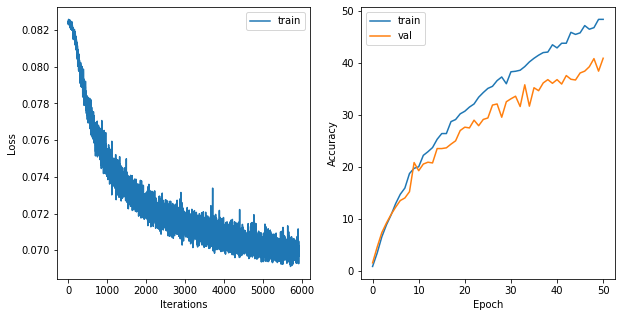

Epoch - 50 | train acc - 48.400000% | val acc - 40.909091%
Iter - 5950 Train loss - 0.070058
Iter - 6000 Train loss - 0.069654
Epoch - 51 | train acc - 47.900000% | val acc - 39.630682%
Iter - 6050 Train loss - 0.070117
Iter - 6100 Train loss - 0.069824
Epoch - 52 | train acc - 49.800000% | val acc - 39.417614%
Iter - 6150 Train loss - 0.069709
Iter - 6200 Train loss - 0.070199
Iter - 6250 Train loss - 0.069960
Epoch - 53 | train acc - 49.500000% | val acc - 40.625000%
Iter - 6300 Train loss - 0.070484
Iter - 6350 Train loss - 0.069945
Epoch - 54 | train acc - 50.100000% | val acc - 40.767045%
Iter - 6400 Train loss - 0.068903
Iter - 6450 Train loss - 0.069893
Epoch - 55 | train acc - 50.300000% | val acc - 40.056818%
Iter - 6500 Train loss - 0.069433
Iter - 6550 Train loss - 0.069469
Iter - 6600 Train loss - 0.069255
Epoch - 56 | train acc - 50.000000% | val acc - 40.909091%
Iter - 6650 Train loss - 0.069896
Iter - 6700 Train loss - 0.069252


In [ ]:
# get the model
import torchvision
# model = resnet50(pretrained=True)
model = torchvision.models.efficientnet_b0(pretrained=True)

# Add a new linear layer as classifier
model.add_module('classifier', nn.Linear(1280, 196))

# model.fc = nn.Sequential(nn.Linear(in_features=2048, out_features=500, bias=True),
                        #  nn.ReLU(),
                        #  nn.Linear(in_features=500, out_features=196, bias=True)) 
if torch.cuda.is_available():
    model = model.to(device)
# model.load_state_dict(torch.load('/content/drive/MyDrive/Intro_to_Deep_Learning/checkpoints_resnet50_test2/ckpt-275.pk'))

batch_size = 64
train_loader, val_loader, test_loader = get_data_loaders(train_data,val_data,test_data,batch_size)


num_epochs = 201
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lr = 0.0001,params=model.parameters(), weight_decay = 1e-4)
info = train(model,
             train_loader,
             val_loader,
             num_epochs,
             criterion,
             optimizer,
             grad_clip = 0.5,
             checkpoint_path='/content/drive/MyDrive/Intro_to_Deep_Learning/checkpoints_resnet50_test2/ckpt-{}.pk')

In [ ]:
# we can take only part of the dataset 

# samp = torch.utils.data.Subset(train_data,[0,1,2,3,4])

In [ ]:
batch_size = 64
train_loader, val_loader, test_loader = get_data_loaders(train_data,val_data,test_data,batch_size)

In [ ]:

num_epochs = 100
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lr = 0.0001,params=model.parameters(), weight_decay = 1e-4)
info = train(model, train_loader, val_loader, num_epochs, criterion, optimizer, grad_clip = 0.5)

Try to make the data more diverse with random crops

In [ ]:
num_epochs = 10
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lr = 0.0001,params=model.parameters(), weight_decay = 1e-4)
info2 = train(model, train_loader, val_loader, num_epochs, criterion, optimizer, grad_clip = 0.5)